In [ ]:
import re
import json
from nltk.tag import pos_tag
from collections import Counter
import requests
from transformers import AutoModelForCausalLM, AutoTokenizer, TextDataset, DataCollatorForLanguageModeling
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pprint


In [ ]:
def fetch_data(api_key, total_requests=100):
    # Base URL for the API
    base_url = "https://api.mediastack.com/v1/news"
    all_articles = []

    for i in range(total_requests):
        # Set parameters for API request, including API key, language, limit, and offset
        params = {
            'access_key': api_key,
            'languages': 'en',
            'limit': 100,
            'offset': i * 100
        }

        # Make the API request
        response = requests.get(base_url, params=params)

        # If request is successful, add the data to all_articles
        if response.status_code == 200:
            data = response.json()
            all_articles.extend(data['data'])
        else:
            # Print an error message if request fails
            print(f"Failed to retrieve data for request {i + 1}")

    # Return the aggregated articles
    return all_articles

# API key for authentication
api_key =  #your own api

# Fetch and store articles
articles = fetch_data(api_key)


In [ ]:

def preprocess_text(text):
    # Removes any character that is not a letter or whitespace from the text.
    # This helps in cleaning the text by removing punctuation, special characters, etc.
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

    # Converts all characters in the text to lowercase to maintain uniformity.
    # This is important because 'Word' and 'word' should be treated as the same word.
    text = text.lower()

    return text


# Modify preprocess_dataset to focus only on title and description
def preprocess_dataset(dataset):
    processed_data = []

    # Iterate through each article in the dataset
    for item in dataset:
        combined_text = ''  # Initialize an empty string to hold combined text

        # Check and add the title to combined_text if it exists
        if item['title']:
            combined_text += preprocess_text(item['title']) + ' '

        # Check and add the description to combined_text if it exists
        if item['description']:
            combined_text += preprocess_text(item['description'])

        # Append the combined, preprocessed text to processed_data
        processed_data.append(combined_text.strip())

    # Return the list of combined and preprocessed text for each article
    return processed_data


preprocessed_articles = preprocess_dataset(articles)

In [ ]:
# saving our file instead of call
with open('preprocessed_articles.txt', 'w', encoding='utf-8') as file:
    for article in preprocessed_articles:
        file.write(article + "\n")

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (694158 > 1024). Running this sequence through the model will result in indexing errors


Streaming output truncated to the last 5000 lines.
Epoch 2, Batch 429, Loss: 1.630051851272583
Epoch 2, Batch 430, Loss: 3.6504154205322266
Epoch 2, Batch 431, Loss: 3.168362617492676
Epoch 2, Batch 432, Loss: 3.7300727367401123
Epoch 2, Batch 433, Loss: 3.3484745025634766
Epoch 2, Batch 434, Loss: 3.1636669635772705
Epoch 2, Batch 435, Loss: 3.735304832458496
Epoch 2, Batch 436, Loss: 3.4920222759246826
Epoch 2, Batch 437, Loss: 3.700664520263672
Epoch 2, Batch 438, Loss: 2.301001787185669
Epoch 2, Batch 439, Loss: 2.463685989379883
Epoch 2, Batch 440, Loss: 2.554309129714966
Epoch 2, Batch 441, Loss: 2.3278181552886963
Epoch 2, Batch 442, Loss: 1.9063814878463745
Epoch 2, Batch 443, Loss: 1.9210147857666016
Epoch 2, Batch 444, Loss: 3.267747640609741
Epoch 2, Batch 445, Loss: 3.153038501739502
Epoch 2, Batch 446, Loss: 3.3296022415161133
Epoch 2, Batch 447, Loss: 2.900350332260132
Epoch 2, Batch 448, Loss: 2.9089677333831787
Epoch 2, Batch 449, Loss: 4.071840763092041
Epoch 2, Batch 

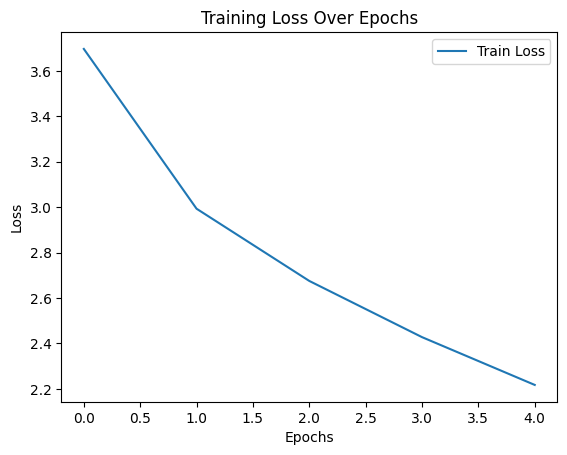

In [ ]:
# Load the tokenizer and model from a pre-trained source
# This is essential for processing the text in the format the model understands
tokenizer = AutoTokenizer.from_pretrained("salesken/content_generation_from_phrases")
model = AutoModelForCausalLM.from_pretrained("salesken/content_generation_from_phrases").to(device)

# Preparing the dataset for training
# We load the preprocessed articles, breaking them into blocks of size 128 for processing
train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="preprocessed_articles.txt",
    block_size=128
)

# Setting up the data collator
# This will format the data properly for language modeling (without masked language modeling)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

# Initialize an empty list to track the training loss
train_loss = []

# Creating a DataLoader for batching the dataset
# This allows us to efficiently load data in batches of size 4, shuffling for randomness
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Setting up the optimizer
# AdamW is an effective optimizer for this kind of model, with a learning rate of 5e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# confirming the device for the model (GPU or CPU)
# It's important to ensure the model is using the right device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Setting the number of training epochs
# Epochs are the number of times the model will see the entire dataset
epochs = 5


# Loop over the specified number of epochs
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    batch_losses = []  # List to store loss for each batch in the epoch

    # Iterate over each batch in the data loader
    for i, batch in enumerate(train_loader):
        inputs = {'input_ids': batch.to(device)}  # Prepare input data
        outputs = model(**inputs, labels=inputs['input_ids'])  # Forward pass
        loss = outputs.loss  # Compute the loss

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters

        batch_losses.append(loss.item())  # Store loss for this batch
        print(f"Epoch {epoch + 1}, Batch {i + 1}, Loss: {loss.item()}")  # Display loss for this batch

    # Calculate and store the average loss for this epoch
    epoch_loss = sum(batch_losses) / len(batch_losses)
    train_loss.append(epoch_loss)  # Store average loss for the epoch
    print(f"Average Loss for Epoch {epoch + 1}: {epoch_loss}")  # Display average loss for this epoch

# Plotting the training loss
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()


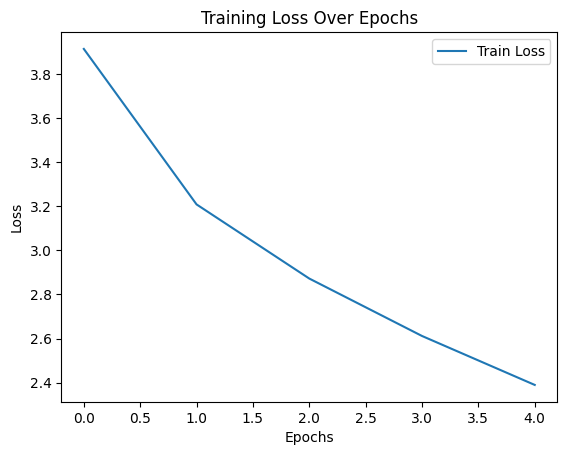

In [ ]:
# Plotting the training loss
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


In [ ]:
model.save_pretrained("./custom-finetuned")


In [ ]:
input_query = ["apple"]
query = " " + input_query[0] + " ~~"

input_ids = tokenizer.encode(query.lower(), return_tensors='pt').to(device)
sample_outputs = model.generate(
    input_ids,
    do_sample=True,
    num_beams=1,
    max_length=40,  # Reduced max length
    temperature=0.1,  # Adjusted temperature
    top_k=30,
    num_return_sequences=10  # Reduced number of return sequences
)

content = []
for i in range(len(sample_outputs)):
    r = tokenizer.decode(sample_outputs[i], skip_special_tokens=True).split('||')[0]
    if ' ~~ ' in r:  # Check if the separator is in the string
        r = r.split(' ~~ ')[1]
        if r not in content:
            content.append(r)

pprint.pprint(content[:10])


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['how to get free trial of apple music app for  january    and apple app for  '
 'january    and apple app for  january   and apple',
 'how to get free trial of apple music app for  free trial of apple music app '
 'for  free trial of apple music app for\n'
 'the best free trial of apple music app for ',
 'how to get free shipping on all of your orders from us to your country usd '
 'shipping rates are calculated based on your country of residence and your '
 'country of residence and country of residence and',
 'apple inc nasdaqapp shares sold by sage mountain advisors llc sage mountain '
 'advisors llc trimmed its position in apple inc nasdaqapp  free report by  '
 'during the third quarter according',
 'how to get free trial of apple inc nasdaqaapl  get free trial is a trial '
 'that lets you unlock a digital version of apple products and services at no '
 'additional charge or price',
 'what are the odds of winning the  nhl championship the  nhl championship '
 'game between the  n